# DATA512_A1_Data_Curation
Jiyu Wang

In this assignment, we collected wikipedia page traffic data with API and performed preprocessing as well as data visualization.

First import some necessary python libraries...

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Data Collection

We will use two different API endpoints, the Legacy Pagecounts API and the Pageviews API, to collect page traffic data from Wikipedia.

The function to call api requires an endpoint and corresponding parameters:

In [2]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

The URLs of two API endpoints are:

In [3]:
ENDPOINT_LEGACY = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
ENDPOINT_PAGEVIEWS = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

We can pre-set some common parameters shared by these two APIs and also create directories to store output:

In [4]:
# common parameters
common_params = {"project" : "en.wikipedia.org",
                 "granularity" : "monthly"}

headers = {
    'User-Agent': 'https://github.com/jiyuw',
    'From': 'jiyuw@uw.edu'
}

# output dir
jsons_dir = 'JSON/'
csv_dir = 'CSV/'
if not os.path.exists(jsons_dir):
    os.mkdir(jsons_dir)
if not os.path.exists(csv_dir):
    os.mkdir(csv_dir)

* Collecting data with Legacy Pagecounts API

The get_legacy_data adds specific parameters and calls the api_call function to request data. The json-style output is stored in the json directory.

In [5]:
# legacy
def get_legacy_data(access, start, end):
    params_legacy = {"access-site" : access,
                     "start" : start,
                     "end" : end}
    params_legacy.update(common_params)
    data = api_call(ENDPOINT_LEGACY, params_legacy)
    filename = f"pagecounts_{access}_{start[:-4]}-{end[:-4]}.json"
    with open(jsons_dir+filename, 'w', encoding='utf-8') as f:
        f.write(json.dumps(data['items'], indent=2))
    print(f"legacy file {filename} created")
    return filename

Set legacy-specific parameters: two types of access, December 2007 as the start month, and July 2016 as the end month.

Loop through list of parameters to collect all types of data and store the file names into a list for further analysis

In [6]:
# legacy-specific parameters
legacy_access = ["desktop-site", "mobile-site"]
legacy_start = "2007120100"
legacy_end = "2016080100"

# save data with different parameters in a list
legacy_files = []
for access in legacy_access:
    legacy_files.append(get_legacy_data(access, legacy_start, legacy_end))

legacy file pagecounts_desktop-site_200712-201608.json created
legacy file pagecounts_mobile-site_200712-201608.json created


* Collecting data with Pageviews API

The get_pageviews_data adds specific parameters and calls the api_call function to request data. The json-style output is stored in the json directory.

In [7]:
# pageviews
def get_pageviews_data(access, start, end):
    params_pageviews = {"access" : access,
                        "agent" : "user",
                        "start" : start,
                        "end" : end}
    params_pageviews.update(common_params)
    data = api_call(ENDPOINT_PAGEVIEWS, params_pageviews)
    filename = f"pageviews_{access}_{start[:-4]}-{end[:-4]}.json"
    with open(jsons_dir+filename, 'w', encoding='utf-8') as f:
        f.write(json.dumps(data['items'], indent=2))
    print(f"pageviews file {filename} created")
    return filename

Set pageview-specific parameters: three types of access, July 2015 as the start month, and September 2020 as the end month.

Loop through list of parameters to collect all types of data and store the file names into a list for further analysis

In [8]:
# pageview-specific parameters
pageviews_access = ["desktop", "mobile-app", "mobile-web"]
pageviews_start = "2015070100"
pageviews_end = "2020100100"

# save data with different parameters in a list
pageviews_files = []
for access in pageviews_access:
    pageviews_files.append(get_pageviews_data(access, pageviews_start, pageviews_end))

pageviews file pageviews_desktop_201507-202010.json created
pageviews file pageviews_mobile-app_201507-202010.json created
pageviews file pageviews_mobile-web_201507-202010.json created


## Data Processing

The collected json-style data will be converted to dataframes and merged to form a final csv file.

The columns in the final csv file are:
- year
- month
- pagecount_all_views
- pagecount_desktop_views
- pagecount_mobile_views
- pageview_all_views
- pageview_desktop_views
- pageview_mobile_views

The json_to_df function takes in the json-style data file and converts into a pandas dataframe with modified column names:

In [9]:
def json_to_df(file_name, file_dir = jsons_dir):
    f = open(file_dir+file_name, 'r')
    data = pd.read_json(f, orient='records', convert_dates=False)
    api_name, access, _ = file_name.split('_')
    new_col_name = f"{api_name[:-1]}_{access}_views"
    data = data.rename(columns={'count':new_col_name, 'views':new_col_name})
    return data[['timestamp', new_col_name]]

Convert all files for legacy and pageviews data into dataframes by calling the json_to_df function

In [10]:
df_ls = [json_to_df(file) for file in legacy_files+pageviews_files]

The dataframes created are then outer joined to form a new dataframe with all columns.

In [11]:
df = df_ls.pop()
while df_ls:
    other = df_ls.pop()
    df = df.merge(other, on='timestamp', how='outer', sort=True)

The 'timestamp' column is processed to create new columns of 'year' and 'month'.

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

Fill the nan values with 0 for the counting columns.

In [13]:
df = df.fillna(0)

For data from the Pageviews API, combine the monthly counts for mobile-web and mobile-app to create a total mobile count column.

In [14]:
df['pageview_mobile_views'] = df['pageview_mobile-web_views'] + df['pageview_mobile-app_views']
df = df.rename(columns={'pagecount_mobile-site_views':'pagecount_mobile_views',
                       'pagecount_desktop-site_views':'pagecount_desktop_views'})

For data from both APIs, combine the counts for mobile and desktop to create a total count column.

In [15]:
df['pagecount_all_views'] = df['pagecount_mobile_views'] + df['pagecount_desktop_views']
df['pageview_all_views'] = df['pageview_mobile_views'] + df['pageview_desktop_views']

Drop unnecessary columns and re-order the rest columns to finalize the dataframe.

In [16]:
df = df.drop(columns=['timestamp', 'pageview_mobile-web_views', 'pageview_mobile-app_views'])
df = df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
              'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

Save the csv file and store in the csv directory.

In [17]:
df.to_csv(csv_dir+'en-wikipedia_traffic_200712-202010.csv', index=False)

## Analyze the data

The created final dataframe is then used to create a visualization to compare view counts of different access types from both APIs.

The dataframe is first imported from the csv file:

In [18]:
df = pd.read_csv(csv_dir+'en-wikipedia_traffic_200712-202010.csv')

Combine the 'year' and 'month' columns into the 'date' column with datetime type.

In [19]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

Convert 0s in the dataset to nan values to unnecessary lines outside of our data range.

In [20]:
df = df.replace(to_replace=0, value=np.nan)

Create the plot with the processed dataframe:
- data from pageview API is plotted with solid lines, while data from the legacy_pagecounts API is plotted with dashed lines.
- colors for different access types: green - desktop, blue - mobile, black - total

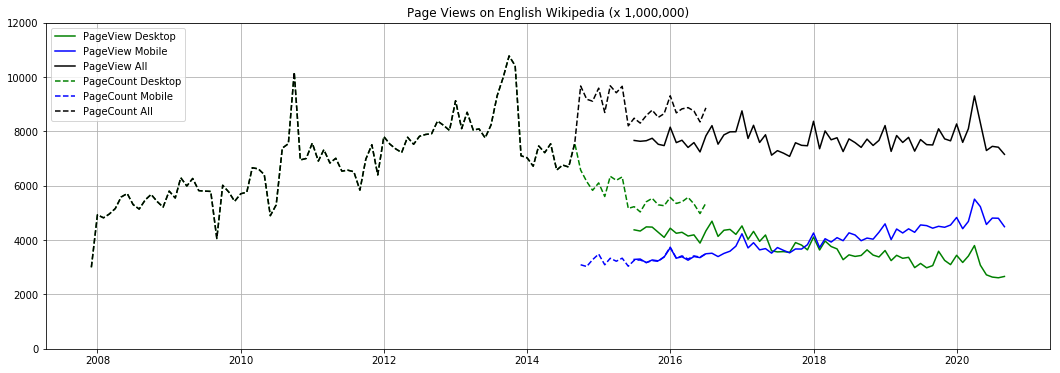

In [21]:
plt.figure(figsize=(18, 6))

# count numbers are divided by 1000000, which is indicated in the title
plt.plot(df.date, df.pageview_desktop_views/1000000, color='green', marker='', linestyle='solid')
plt.plot(df.date, df.pageview_mobile_views/1000000, color='blue', marker='', linestyle='solid')
plt.plot(df.date, df.pageview_all_views/1000000, color='black', marker='', linestyle='solid')

plt.plot(df.date, df.pagecount_desktop_views/1000000, color='green', marker='', linestyle='dashed')
plt.plot(df.date, df.pagecount_mobile_views/1000000, color='blue', marker='', linestyle='dashed')
plt.plot(df.date, df.pagecount_all_views/1000000, color='black', marker='', linestyle='dashed')

plt.ticklabel_format(axis='y', style='plain')
plt.ylim([0, 12000])
plt.grid(which='major')
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.legend(["PageView Desktop", "PageView Mobile", "PageView All", "PageCount Desktop", "PageCount Mobile", "PageCount All"])
plt.savefig('pageviews_wikipedia.png', dpi=200)

The counts of pageview is always not larger than the counts of pagecounts, since pageview data excludes visits from spiders/crawlers.

While the total page views stay approximately the same, more and more views are switching from desktop to mobile visits.